## House Prices: Advanced Regression Techniques
#### Kaggle Competition 

Cтраница соревнования: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Data Sources: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [1]:
!python --version

Python 3.6.6


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', 80)
import numpy as np

from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Arial', 'Times New Roman', 'Tahoma'
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns

In [3]:
train, test = pd.read_csv('train.csv', index_col=['Id']), pd.read_csv('test.csv', index_col=['Id'])

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 

In [5]:
# Тестовая выборка короче на столбец (ожидаемо отсутствует целевой признак)
train.shape, test.shape

((1460, 80), (1459, 79))

Отметим, что обе выборки (как обучающая, так и тестовая) содержат пропуски.

In [6]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Отметим, что данные имеют разный масштаб (и, следовательно, не годятся для подачи в линейные модели в необработанном виде).

In [8]:
# Посмотрим на распределение целевого признака
target = train['SalePrice']
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

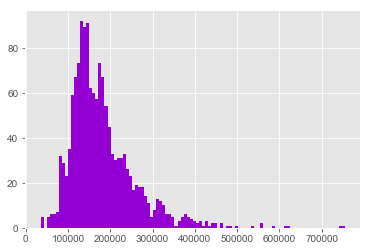

In [9]:
plt.hist(target, color='darkviolet', bins=100);

In [10]:
# Скошенность целевого признака
target.skew()

1.8828757597682129

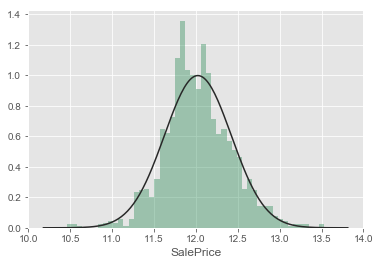

In [11]:
# Желание использовать линейные модели намекает на необходимость приведения таргета к нормальному
target_log = np.log(target)
sns.distplot(target_log, fit=norm, kde=False, color='seagreen', bins=50);

In [12]:
target_log.skew()

0.12133506220520406

После логарифимирования скошенность целевого признака уменьшилась, но стоит опробовать другие преобразования для лучшего приближения исходного распределения к нормальному.

In [13]:
# Отделим числовые признаки от категориальных
cat_cols = train.select_dtypes(include='object').columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns[:-1]

In [14]:
# Исследование корреляции числовых признаков и таргета
corr_with_target = train[num_cols].corrwith(train['SalePrice'], method='spearman')
abs(corr_with_target).sort_values(ascending=False)[:10]

OverallQual     0.809829
GrLivArea       0.731310
GarageCars      0.690711
YearBuilt       0.652682
GarageArea      0.649379
FullBath        0.635957
TotalBsmtSF     0.602725
GarageYrBlt     0.593788
1stFlrSF        0.575408
YearRemodAdd    0.571159
dtype: float64

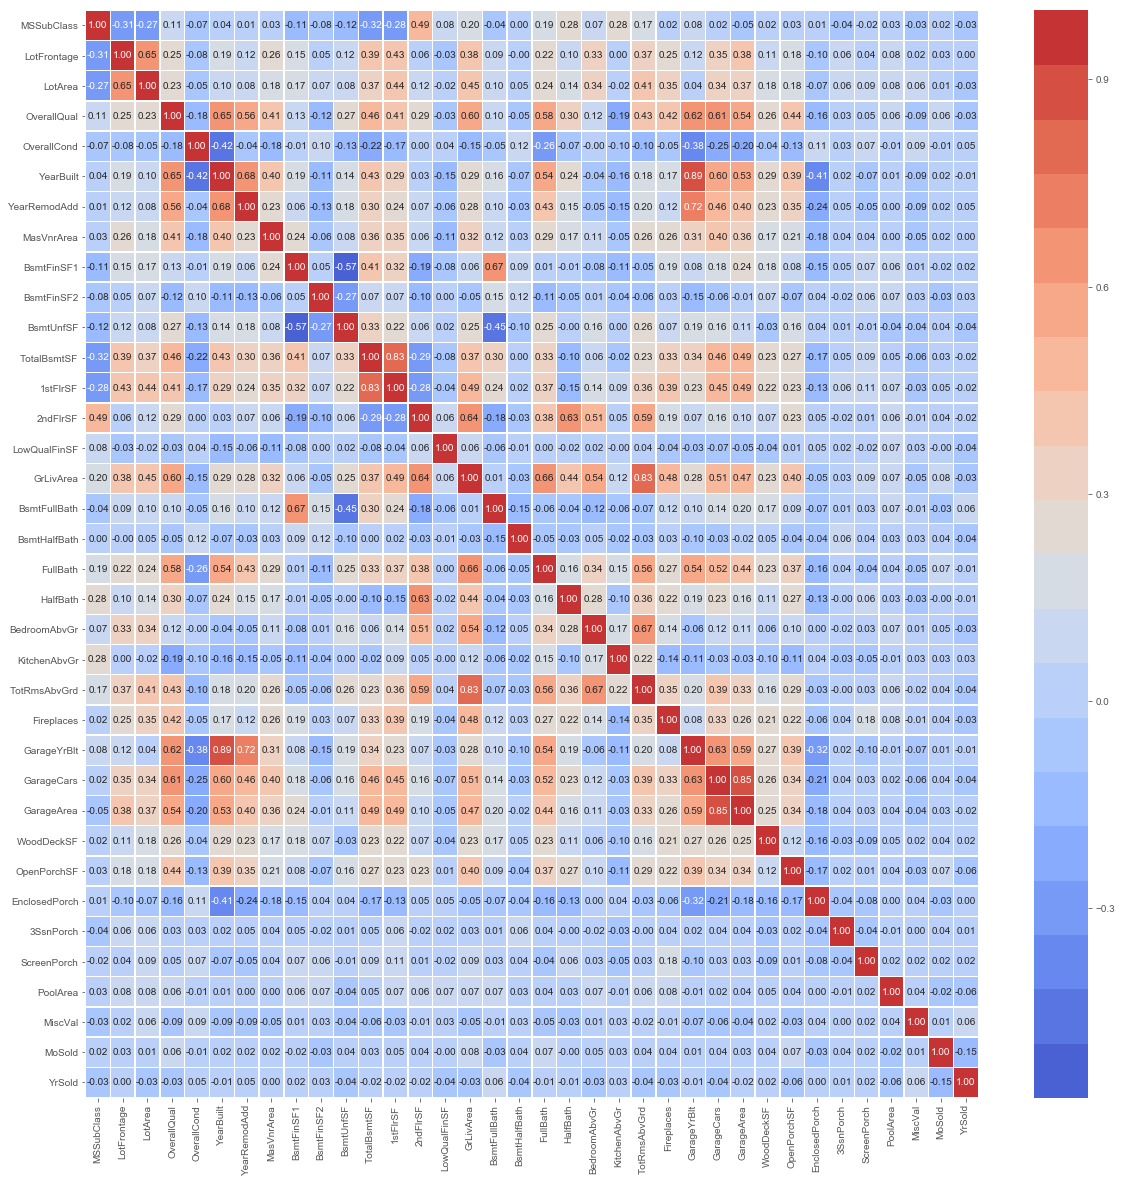

In [15]:
# Тепловая карта попарной линейной корреляции числовых признаков
fig, axes = plt.subplots(figsize=(20, 20))
sns.heatmap(train[num_cols].corr(method='spearman'), annot=True, fmt='.2f', ax=axes, linewidths=.5, 
            cmap=sns.color_palette('coolwarm', n_colors=20));

Высокую попарную корреляцию обнаруживают признаки **`Год постройки дома`** и **`Год постройки гаража`**, **`Площадь первого этажа`** и **`Общая площадь подвальных помещений`**, а также **`Жилая площадь`** и **`Общее количество комнат`**.

### Исследование признаков
Исследование признака **`Жилая площадь`**

In [16]:
# Автором датасета рекомендовано исключить из выборки дома площадью более 4000 квадратных футов
train_without_4000 = train[train['GrLivArea'] < 4000]

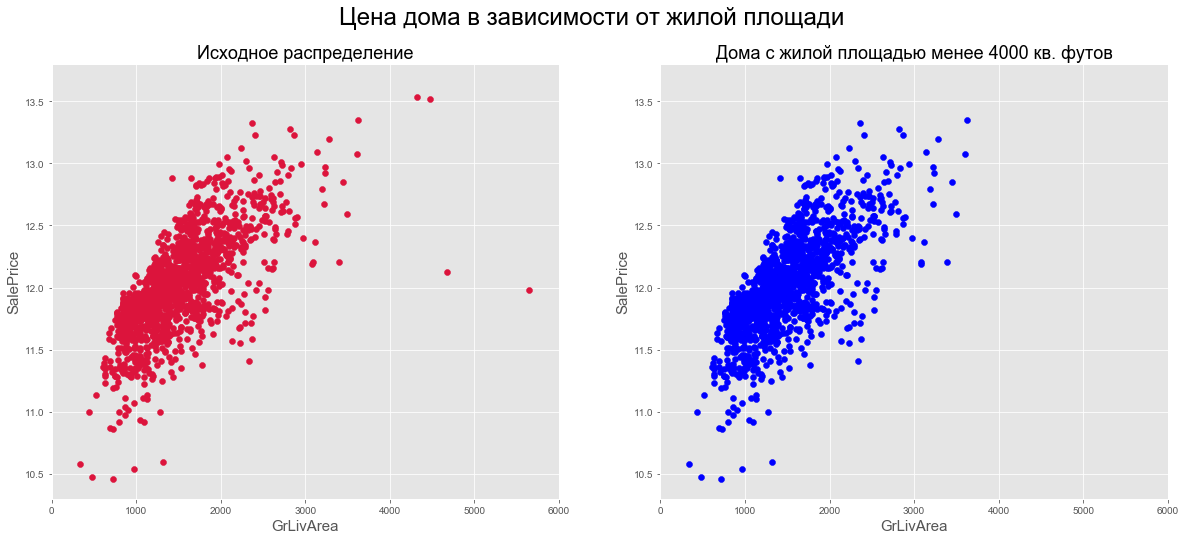

In [17]:
# Визуализируем изменения
fig = plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.suptitle('Цена дома в зависимости от жилой площади', size=24, y=0.98)

axes[0].scatter(x=train['GrLivArea'], y=target_log, color='crimson')
axes[0].set_xlim(0, 6000)
axes[0].set_ylim(10.3, 13.8)
axes[0].set_xlabel('GrLivArea', fontsize=15)
axes[0].set_ylabel('SalePrice', fontsize=15)
axes[0].set_title('Исходное распределение', fontsize=18)

axes[1].scatter(x=train_without_4000['GrLivArea'], y=np.log(train_without_4000['SalePrice']), color='b')
axes[1].set_xlim(0, 6000)
axes[1].set_ylim(10.3, 13.8) 
axes[1].set_xlabel('GrLivArea', fontsize=15)
axes[1].set_ylabel('SalePrice', fontsize=15)
axes[1].set_title('Дома с жилой площадью менее 4000 кв. футов', fontsize=18)
    
plt.subplots_adjust(hspace=0.3);

### Работа с пропусками в данных

In [18]:
# Посмотрим на пропуски в данных
X = train_without_4000.drop('SalePrice', axis=1)

missing_values = pd.DataFrame(data=[X.isnull().sum(), test.isnull().sum()], 
                index=['train_without_4000', 'test']).transpose().sort_values(by='train_without_4000', ascending=False)

missing_values[:20]

,train_without_4000,test
PoolQC,1451,1456
MiscFeature,1402,1408
Alley,1365,1352
Fence,1176,1169
FireplaceQu,690,730
LotFrontage,259,227
GarageType,81,76
GarageYrBlt,81,78
GarageQual,81,78
GarageCond,81,78


Заполним пропуски в данных согласно смыслу признаков. 

Отсутствующих данных в категориальных признаках мало, заполним их наиболее часто встречающимися значениями. Вместо недостающих площадей впишем медианные значения. Пропуски в вещественных признаках, смысл которых (скорее всего) означает отсутствие соответствующего жизненного блага, занулим, а в категориальных - заполним значением 'None'.

In [19]:
X.LotFrontage.median(), test.LotFrontage.median()

(69.0, 67.0)

In [20]:
X['MSZoning'].mode()

0    RL
dtype: object

In [21]:
# Заполнение пропусков медианами
X.LotFrontage, test.LotFrontage = \
    X['LotFrontage'].fillna(X.LotFrontage.median()), test['LotFrontage'].fillna(X.LotFrontage.median())

In [22]:
# Заполнение нулями пропусков в остальных вещественных признаках
X[num_cols.drop('LotFrontage')], test[num_cols.drop('LotFrontage')] = \
    X[num_cols.drop('LotFrontage')].fillna(0), test[num_cols.drop('LotFrontage')].fillna(0)

In [23]:
# Заполнение пропусков в категориальных признаках
X[['Exterior1st', 'Exterior2nd']], test[['Exterior1st', 'Exterior2nd']] = \
                    X[['Exterior1st', 'Exterior2nd']].fillna('Other'), \
                    test[['Exterior1st', 'Exterior2nd']].fillna('Other')
X['Electrical'] = X['Electrical'].fillna('SBrkr')
test[['MSZoning', 'Utilities', 'KitchenQual', 'Functional', 'SaleType']] = \
    test[['MSZoning', 'Utilities', 'KitchenQual', 'Functional', 'SaleType']].fillna(value={'MSZoning': 'RL', 
    'Utilities': 'AllPub', 'Functional': 'Typ', 'SaleType': 'WD', 'KitchenQual': 'TA'})

In [24]:
# Заполнение значением 'None' пропусков в оставшихся категориальных признаках
cat_cols_to_none = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 
                    'Fence', 'FireplaceQu', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 
                    'MasVnrType', 'MiscFeature', 'PoolQC']

In [25]:
X[cat_cols_to_none], test[cat_cols_to_none] = X[cat_cols_to_none].fillna('None'), \
                                            test[cat_cols_to_none].fillna('None')

In [26]:
# Убедимся, что теперь пропуски в данных отсутствуют
X.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

### Кодирование категориальных переменных

In [27]:
# Кодирование относительными частотами наблюдений в категории переменной
for col in cat_cols:
    freq = X[col].value_counts()/len(X)
    X[col + '_freq'] = X[col].map(freq)
    test[col + '_freq'] = test[col].map(freq)

In [28]:
# Подготовка выборок для подачи на вход алгоритму
X_train = pd.concat([X[num_cols], X[cat_cols+'_freq']], axis=1)
X_test = pd.concat([test[num_cols], test[cat_cols+'_freq']], axis=1)
X_test['Exterior1st_freq'].fillna(0, inplace=True)

### Случайный лес

In [29]:
SEED=0
y_train = train_without_4000['SalePrice']

rfr_model = RandomForestRegressor(n_estimators=1000, max_depth=50, n_jobs=-1, 
                                       oob_score=True, random_state=SEED)

In [30]:
rfr_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [31]:
rfr_model.oob_score_

0.8878152457991461

In [32]:
pred_prices = rfr_model.predict(X_test)
pred_prices

array([127524.949, 155474.545, 179429.923, ..., 154860.347, 111322.307,
       229250.958])

In [33]:
submission = pd.DataFrame({'Id': test.index, 'SalePrice': pred_prices})
submission.to_csv('nth_submission.csv', index=False)

### Гребневая регрессия

In [34]:
y_train = np.log(train_without_4000['SalePrice'])

# Стандартизация числовых признаков
scaler = StandardScaler(copy=False)
X_train_real = pd.DataFrame(scaler.fit_transform(X[num_cols].astype('float64')), 
                          index=X.index, columns=num_cols)
X_test_real = pd.DataFrame(scaler.transform(test[num_cols].astype('float64')), 
                          index=test.index, columns=num_cols)

In [35]:
# Подготовка выборок для подачи на вход алгоритму
X_train = pd.concat([X_train_real, X[cat_cols+'_freq']], axis=1)
X_test = pd.concat([X_test_real, test[cat_cols+'_freq']], axis=1)
X_test['Exterior1st_freq'].fillna(0, inplace=True)

In [36]:
ridge_model = Ridge(alpha=0.01, solver='svd', random_state=SEED)

In [37]:
# Разбиение обучающей выборки для проверки качества модели на кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [38]:
# Проверка качества модели на кросс-валидации
rmse_cv = cross_val_score(ridge_model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=kf)
rmse_cv.mean()

-0.014817680849783858

In [39]:
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=0, solver='svd', tol=0.001)

In [40]:
ridge_model.score(X_train, y_train)

0.918014162340787

In [41]:
ridge_predictions = np.exp(ridge_model.predict(X_test))
ridge_predictions

array([109708.42323222, 157823.23905335, 171638.38523819, ...,
       177599.51534258, 112030.86868131, 238145.84139013])

In [42]:
submission = pd.DataFrame({'Id': test.index, 'SalePrice': pred_prices})
submission.to_csv('submission.csv', index=False)

### Пути улучшения:
+ Исследовать выбросы остальных (кроме `GrLivArea`) численных признаков. Если выбранный класс моделей неробастен, то удалить или преобразовать экстремальные объекты. В случае удаления (чего бы то ни было и когда бы то ни было)  руководствоваться смыслом признаков, здравым смыслом и жизненным опытом.


+ Экспериментировать со способами заполнения пропусков в данных, способами кодировки категориальных переменных.


+ Конструирование и отбор признаков.


+ При использовании линейных моделей опробовать различные преобразования вещественных признаков для максимизации их нормальности (чего теоретически требуют линейные модели).


+ Присмотреться повнимательней к корреляции признаков (как вещественных, так и категориальных) между собой, при необходимости удалить высококоррелирующие признаки и/или на их основе сконструировать новые признаки. 


+ Изучить корреляции признаков с таргетом, и, возможно, удалить признаки с наименьшим вкладом.


+ Разные способы масштабирования вещественных признаков (если используем линейныe модели) могут давать различные результаты.


+ Сделать предсказания с помощью алгоритмов различных классов и выбрать модель-победителя.


+ Осознавать, что любые предпринятые попытки улучшить скор могут потерпеть фиаско, и вовремя остановиться на приемлемом качестве.